# CWA Determination: Alternate Model

## Authenticate to Colab

In [1]:
# AUTHENTICATE to Google Colab using your Colab credentials
from google.colab import auth
auth.authenticate_user()

## Mount GDrive

In [2]:
# IMPORT & MOUNT gDrive so we can access files from here
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Python Packages

In [3]:
# install pickle5 
!pip3 install pickle5

# install xgboost
!pip install xgboost

# install iterative stratification
!pip install iterative-stratification

     |████████████████████████████████| 133kB 12.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219258 sha256=b271a077c786e1fef55049e305ebd7ebc0f2aae534e3faa4794d888726bb5dd2
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [4]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import isnan

import pickle5 as pickle
import os
import random

import matplotlib.pyplot as plt

from collections import Counter

import time

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

import seaborn as sns

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

# Set the randomizer seed so results are the same each time.
np.random.seed(123)

pd.set_option('display.float_format', '{:.2f}'.format)

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load Data

In [251]:
# Load Data

# 1 - Load 15k data
full_df = pd.read_csv(r"/content/drive/MyDrive/Colab/Data/2021.03.17_full_dataset.csv")

# 2 - Generate regional data
# for d in full_df['district'].unique():
#   tmp = full_df[full_df['district'] == d]
#   region_data = tmp.copy()
#   region_name = "region_"+ d
#   region_data.to_csv(r"/content/drive/MyDrive/Colab/Data/"+ region_name + ".csv")

# 3 - Load regional data
# region_df = pd.read_csv(r"/content/drive/MyDrive/Colab/Data/region_Portland.csv")


In [269]:
train_df= full_df[full_df.district.isin(['Chicago','Norfolk'])]

## Extract model data

In [252]:
# Extract model data

# for regions
model_data = region_df.copy()

# Lat/Lon Feature Engineering
model_data['x_coord'] = np.cos(model_data['latitude']) * np.cos(model_data['longitude'])
model_data['y_coord'] = np.cos(model_data['latitude']) * np.sin(model_data['longitude'])
model_data['z_coord'] = np.sin(model_data['latitude'])

len(model_data["da_number"])

106

## Prepare X, Y data

In [253]:
Y = model_data[["cwa_determination"]]

X = model_data[['x_coord', 'y_coord', 'z_coord',
               'potential_wetland',
               'hydclprs', 
               'aws025wta',
               'slopegradd',
               'wtdepannmi',
               'flodfreqdc',
               'pondfreqpr',
               'wtdepaprju',
                
               'fl_areasqkm_sum_200m',
               'fl_gnis_name_ind_count_200m',
               'fl_totdasqkm_sum_200m',
               'fl_streamorde_sum_200m',
               'fl_startflag_sum_200m',
               'fl_divergence_mean_200m',
                
               'wb_area_sum_200m',
               'wb_gnis_name_ind_count_200m',
                
               'fl_areasqkm_sum_2500m',
               'fl_gnis_name_ind_count_2500m',
               'fl_totdasqkm_sum_2500m',
               'fl_flow_type_sum_2500m',
               'fl_streamorde_sum_2500m',
               'fl_intephem_mean_2500m',
               'fl_startflag_sum_2500m',
               'fl_divergence_mean_2500m',
                
               'wb_area_sum_2500m',
               'wb_gnis_name_ind_count_2500m',
                
                'elevation_mean_200m',
                'elevation_mean_2500m',
                'elevation_stdev_200m',
                'elevation_stdev_2500m',

                'fl_ftype_artificialpath_200m',
                'fl_ftype_artificialpath_2500m',
                'fl_ftype_canalditch_200m',
                'fl_ftype_canalditch_2500m',
                'fl_ftype_coastline_200m',
                'fl_ftype_coastline_2500m',
                'fl_ftype_connector_2500m',
                'fl_ftype_pipeline_2500m',
                'fl_ftype_streamriver_200m',
                'fl_ftype_streamriver_2500m',

                'wb_ftype_canalditch_200m',
                'wb_ftype_canalditch_2500m',
                'wb_ftype_connector_2500m',
                'wb_ftype_pipeline_200m',
                'wb_ftype_streamriver_2500m',

                'nwi_WATER_REGIME_NAME_artificially_flooded_2500m',
                'nwi_WATER_REGIME_NAME_continuously__saturated_2500m',
                'nwi_WATER_REGIME_NAME_intermittently_exposed_200m',
                'nwi_WATER_REGIME_NAME_intermittently_exposed_2500m',
                'nwi_WATER_REGIME_NAME_intermittently_flooded_2500m',
                'nwi_WATER_REGIME_NAME_irregularly_exposed_2500m',
                'nwi_WATER_REGIME_NAME_irregularly_flooded_200m',
                'nwi_WATER_REGIME_NAME_irregularly_flooded_2500m',
                'nwi_WATER_REGIME_NAME_permanently_flooded-tidal_200m',
                'nwi_WATER_REGIME_NAME_permanently_flooded-tidal_2500m',
                'nwi_WATER_REGIME_NAME_permanently_flooded_200m',
                'nwi_WATER_REGIME_NAME_permanently_flooded_2500m',
                'nwi_WATER_REGIME_NAME_regularly_flooded_200m',
                'nwi_WATER_REGIME_NAME_regularly_flooded_2500m',
                'nwi_WATER_REGIME_NAME_seasonally_flooded-tidal_2500m',
                'nwi_WATER_REGIME_NAME_seasonally_flooded/saturated_2500m',
                'nwi_WATER_REGIME_NAME_seasonally_flooded_200m',
                'nwi_WATER_REGIME_NAME_seasonally_flooded_2500m',
                'nwi_WATER_REGIME_NAME_seasonally_saturated_200m',
                'nwi_WATER_REGIME_NAME_seasonally_saturated_2500m',
                'nwi_WATER_REGIME_NAME_semipermanently_flooded-tidal_2500m',
                'nwi_WATER_REGIME_NAME_semipermanently_flooded_200m',
                'nwi_WATER_REGIME_NAME_semipermanently_flooded_2500m',
                'nwi_WATER_REGIME_NAME_subtidal_200m',
                'nwi_WATER_REGIME_NAME_subtidal_2500m',
                'nwi_WATER_REGIME_NAME_temporary_flooded-tidal_2500m',
                'nwi_WATER_REGIME_NAME_temporary_flooded_200m',
                'nwi_WATER_REGIME_NAME_temporary_flooded_2500m',
                'nwi_WATER_REGIME_NAME_zzz_200m',
                'nwi_WATER_REGIME_NAME_zzz_2500m',

                'nwi_CLASS_NAME_aquatic_bed_200m',
                'nwi_CLASS_NAME_aquatic_bed_2500m',
                'nwi_CLASS_NAME_emergent_200m',
                'nwi_CLASS_NAME_emergent_2500m',
                'nwi_CLASS_NAME_forested_200m',
                'nwi_CLASS_NAME_forested_2500m',
                'nwi_CLASS_NAME_reef_2500m',
                'nwi_CLASS_NAME_rocky_shore_2500m',
                'nwi_CLASS_NAME_scrub-shrub_200m',
                'nwi_CLASS_NAME_scrub-shrub_2500m',
                'nwi_CLASS_NAME_streambed_200m',
                'nwi_CLASS_NAME_streambed_2500m',
                'nwi_CLASS_NAME_unconsolidated_bottom_200m',
                'nwi_CLASS_NAME_unconsolidated_bottom_2500m',
                'nwi_CLASS_NAME_unconsolidated_shore_200m',
                'nwi_CLASS_NAME_unconsolidated_shore_2500m',
                'nwi_CLASS_NAME_zzz_2500m'
               ]]



## Pre-process X, Y Data

In [254]:
# One Hot Encode categorical variables
cat_cols = ['flodfreqdc']
for c in cat_cols:
  enc_df = pd.get_dummies(X[c], prefix='')
  X = X.join(enc_df)
  X.drop(c, axis=1, inplace=True)


# Impute nans 
for c in X.columns:
  # X.fillna(value=X[c].mean(), inplace=True)
  X.fillna(value=X[c].mode()[0], inplace=True)

## Train-Test Split

In [255]:
# Shobha's split: Method 1
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)


# Test-train split: Method 2 - shuffle stratified with random state set to zero
# This method ensures shuffling, random selection as well as balance of classes in both train and test sets.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, Y): # sss.split returns indices to split data
  X_train, X_test = X.loc[train_index], X.loc[test_index] 
  Y_train, Y_test = Y.loc[train_index], Y.loc[test_index] 


# to verify
print("\nTraining Set Samples:", len(X_train["x_coord"]))
print("Test Set Samples:",len(X_test["x_coord"]))
a1 = Y_train.sum()
a2 = Y_test.sum()
b1 = len(X_train["x_coord"])
b2 = len(X_test["x_coord"])
print("\nTraining Set Class Ratio:", round(a1/(b1-a1),2))
print("Test Set Class Ratio:", round(a2/(b2-a2),2))


Training Set Samples: 84
Test Set Samples: 22

Training Set Class Ratio: cwa_determination   1.00
dtype: float64
Test Set Class Ratio: cwa_determination   1.00
dtype: float64


## Scale Data

In [256]:
# Scale data
# Standard Scaler - Z-score Normalization / Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

## Run XGB

XGBoost Model


Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.27      0.37        11
           1       0.53      0.82      0.64        11

    accuracy                           0.55        22
   macro avg       0.56      0.55      0.51        22
weighted avg       0.56      0.55      0.51        22

Balanced Accuracy Score: 54.55%
AUC: 0.545 




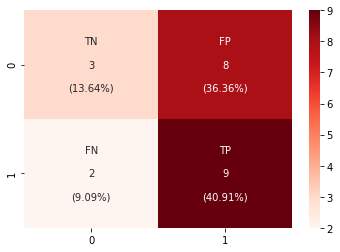

In [257]:
# Learning rate = 0.1 and number of estimators = 1000

y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

# Instantiate model
clf = XGBClassifier(
 # General Params
 booster='gbtree',
 silent=0,
 
 # Booster Params 
 learning_rate=0.1, 
 n_estimators=1000,
 max_depth=5,
 min_child_weight=0.8,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 reg_lambda=1,

 # Learning Task Params
 objective='binary:logistic',
 seed=27,
 eval_metric='error'
 ) 

# Train model
clf.fit(X_train, y_train)

# Predict 
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

print("XGBoost Model\n")

# print classification report
result1 = classification_report(y_test, y_pred)
print("\nClassification Report:\n",)
print(metrics.classification_report(y_test, y_pred, digits=2))

# print accuracy score
print("Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test, y_pred)*100))

# calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc, "\n\n")

# Generate pretty Confusion Matrix
result = confusion_matrix(y_test, y_pred)
group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')

## Extract and Examine XGB FNs

In [ ]:
# convert predicted values into a dataframe with index corresponding to Y_test df
y_pred_df = pd.DataFrame(y_pred, columns = ['cwa_predicted'], index = Y_test.index)

# left merge predicted values with model_data
analysis_df = y_pred_df.merge(model_data, how='left', left_on=y_pred_df.index, right_on=model_data.index)

# compute difference of predicted and actual class labels
analysis_df['diff'] = analysis_df['cwa_determination'] - analysis_df['cwa_predicted'] 

# Extract samples that are incorrectly classified
# FNs are sites that have been determined as "under jurisdiction" by the model but have been deemed "non-jurisdicitional" after field assessments
# If prediction is correct, diff is 0 
# If prediction is FP,  diff is -1 
# If prediction is FN, diff is 1

xgb_fn_list = analysis_df[['da_number', 'cwa1', 'cwa2', 'cwa3', 'cwa4', 'cwa5', 'cwa6', 'cwa7', 'cwa8', 'cwa9']][analysis_df['diff'] == 1]
xgb_fp_list = analysis_df[['da_number', 'cwa1', 'cwa2', 'cwa3', 'cwa4', 'cwa5', 'cwa6', 'cwa7', 'cwa8', 'cwa9']][analysis_df['diff'] == -1]

# save to file
xgb_fn_list.to_csv(r"/content/drive/MyDrive/Colab/altmodel/FN-Analysis/xgb_fn.csv ")
xgb_fp_list.to_csv(r"/content/drive/MyDrive/Colab/altmodel/FN-Analysis/xgb_fp.csv ")


In [ ]:
# FNs by checkbox
xgb_fn_list.describe()

,cwa1,cwa2,cwa3,cwa4,cwa5,cwa6,cwa7,cwa8,cwa9
count,406.00,406.00,406.00,406.00,406.00,406.00,406.00,406.00,406.00
mean,0.12,0.13,0.49,0.12,0.46,0.13,0.06,0.04,0.04
std,0.32,0.34,0.50,0.32,0.50,0.34,0.23,0.19,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Generate Feature Importance

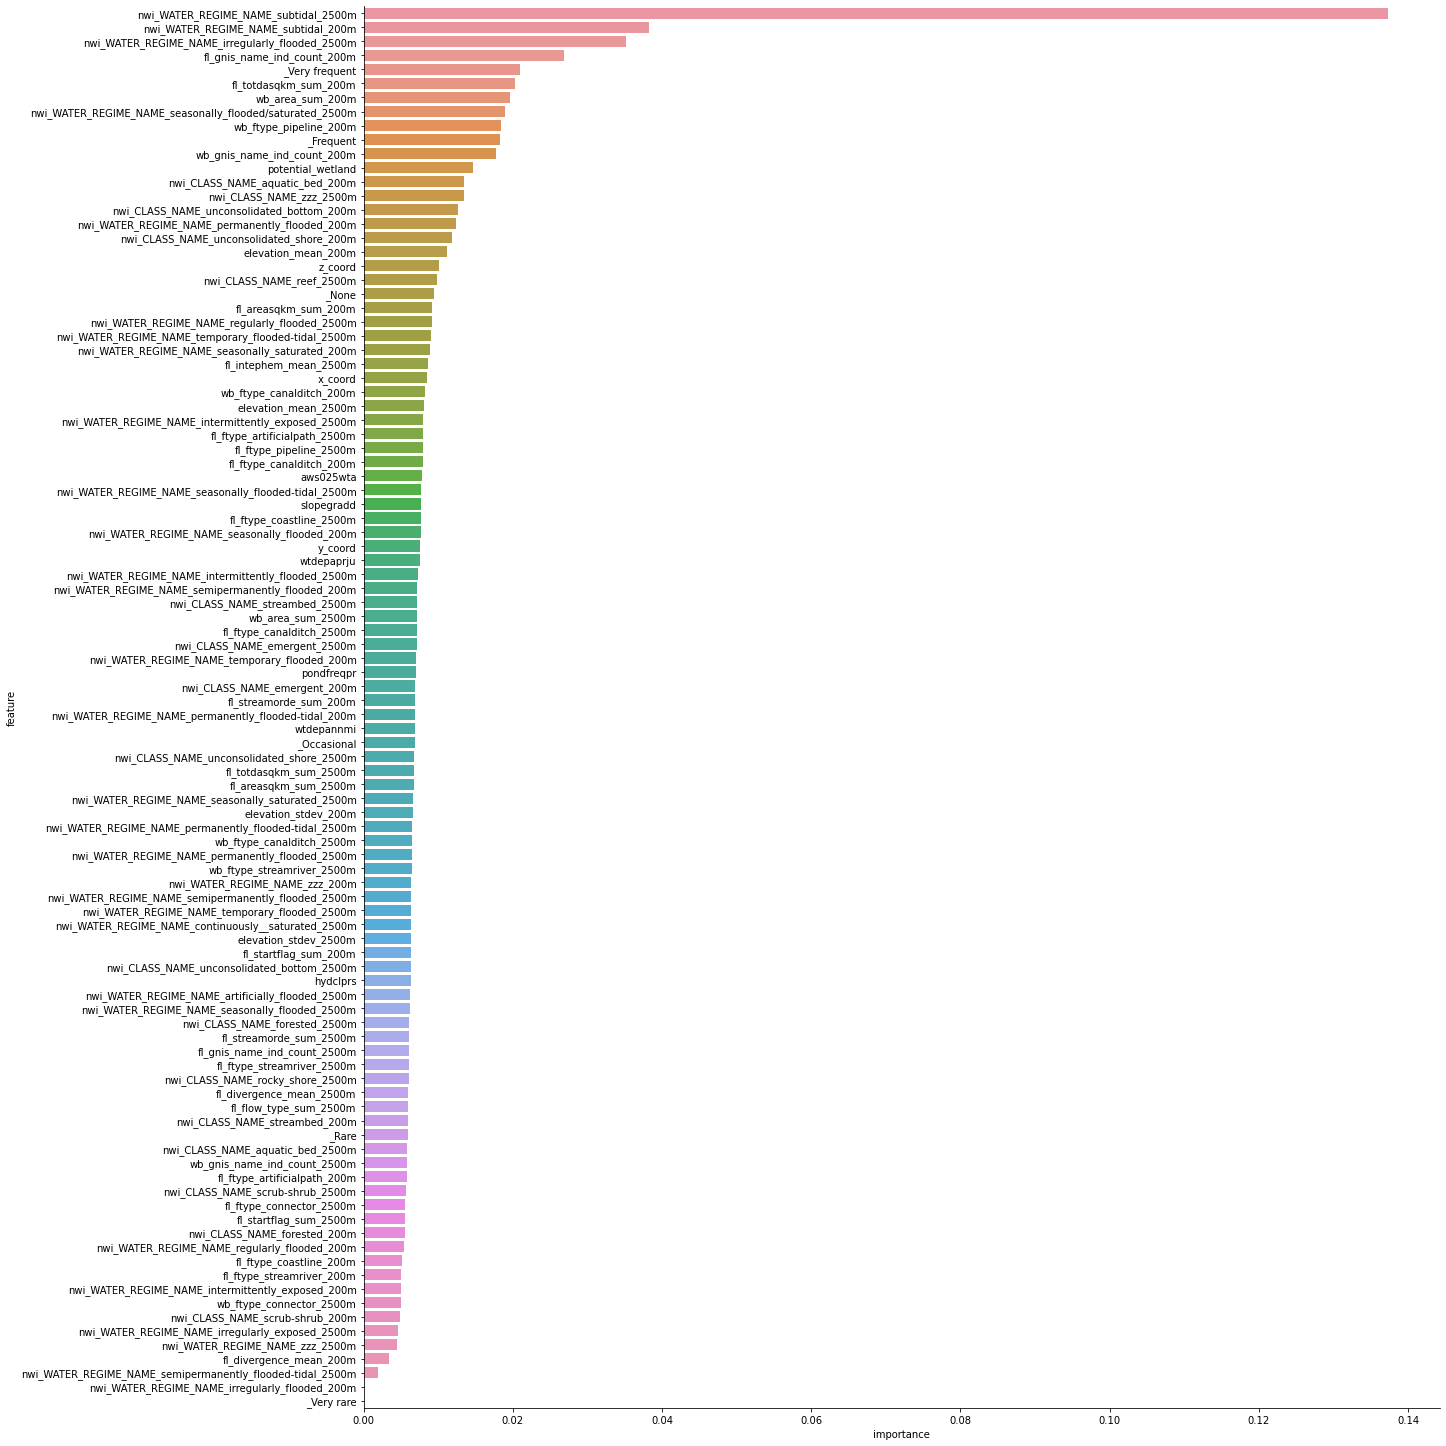

In [ ]:
# generate pretty feature importance
rfc_fi = pd.DataFrame({'feature':X_train.columns,'importance':clf.feature_importances_}).sort_values(by='importance',ascending=False)

sns.catplot(y='feature',x='importance',data=rfc_fi,kind='bar',aspect=1, height=20).set_yticklabels(rotation=0);